In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка данных
train = pd.read_csv('/content/train_data.csv')
test = pd.read_csv('/content/test_data.csv')
sam_sub = pd.read_csv('/content/sample_submission_data.csv')

In [3]:
# Предобработка данных
categorical_cols = train.select_dtypes(include=['object']).columns.intersection(test.columns)
for col in categorical_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)

In [4]:
# Заполнение пропусков для числовых колонок
numeric_cols = [col for col in train.select_dtypes(include=['float64', 'int64']).columns if col in test.columns]

train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].mean())
test[numeric_cols] = test[numeric_cols].fillna(test[numeric_cols].mean())

In [9]:
# Кодирование категориальных переменных
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)
# Убедимся, что тестовый набор имеет те же колонки, что и тренировочный
test = test.reindex(columns=train.columns, fill_value=0)
# Определение признаков и целевой переменной
X = train.drop('Depression', axis=1)
y = train['Depression']

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.3 MB/s eta 0:00:00


In [8]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=607)

def objective(trial):
    colsample_bytree= trial.suggest_float('colsample_bytree',0,1)
    n_estimators = trial.suggest_int('n_estimators', 400,1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01,0.1)
    reg_lambda = trial.suggest_float('reg_lambda', 0,4)
    reg_alpha = trial.suggest_float('reg_alpha', 0,4)
    max_depth = trial.suggest_int('max_depth', 2,10)
    gamma = trial.suggest_float('gamma', 0,0.5)
    eval_metric='auc'

    model = XGBClassifier(
    colsample_bytree = colsample_bytree,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    gamma=gamma,
    eval_metric='auc',
    random_state=607
)
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    return score

In [11]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=607))
optuna.logging.set_verbosity(optuna.logging.WARNING)

def log_best_trial(study, trial):
    if study.best_trial == trial:
        print(f"New best trial: {trial.number} with value: {trial.value} and params: {trial.params}")


study.optimize(objective, n_trials=100,callbacks=[log_best_trial])

[I 2025-05-08 17:56:45,261] A new study created in memory with name: no-name-0151bd25-5fe3-48e2-8ec1-8557aabe6c4f


New best trial: 0 with value: 0.9730517568312002 and params: {'colsample_bytree': 0.9241441149445456, 'n_estimators': 480, 'learning_rate': 0.01934695515938726, 'reg_lambda': 0.995746986500277, 'reg_alpha': 0.7922495581786353, 'max_depth': 3, 'gamma': 0.00960148482380424}
New best trial: 1 with value: 0.9750513415719075 and params: {'colsample_bytree': 0.1621141939217663, 'n_estimators': 866, 'learning_rate': 0.01830911692556304, 'reg_lambda': 2.9106714720433975, 'reg_alpha': 2.3081746881941307, 'max_depth': 8, 'gamma': 0.2014396057468147}
New best trial: 3 with value: 0.9752241286429882 and params: {'colsample_bytree': 0.14492566230028125, 'n_estimators': 714, 'learning_rate': 0.0638419910172031, 'reg_lambda': 0.799541013102012, 'reg_alpha': 2.5068192947954713, 'max_depth': 8, 'gamma': 0.2743399323353837}
New best trial: 6 with value: 0.9752544504773071 and params: {'colsample_bytree': 0.1644800532756021, 'n_estimators': 654, 'learning_rate': 0.06302637503740172, 'reg_lambda': 0.85247

In [12]:
best_params = study.best_params
best_score = study.best_value
print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy: {best_score:.6f}")

Best Hyperparameters: {'colsample_bytree': 0.0958871841005362, 'n_estimators': 843, 'learning_rate': 0.08000905616080559, 'reg_lambda': 3.291378479375312, 'reg_alpha': 0.2978198706515829, 'max_depth': 3, 'gamma': 0.01591794842638572}
Best Accuracy: 0.975383


In [13]:
optuna.visualization.plot_param_importances(study)

In [14]:
best_params = study.best_params
best_score = study.best_value
print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy: {best_score:.6f}")

n_estimators = best_params['n_estimators']
reg_alpha = best_params['reg_alpha']
learning_rate = best_params['learning_rate']
reg_lambda = best_params['reg_lambda']
max_depth = best_params['max_depth']
colsample_bytree = best_params['colsample_bytree']
gamma = best_params['gamma']

Best Hyperparameters: {'colsample_bytree': 0.0958871841005362, 'n_estimators': 843, 'learning_rate': 0.08000905616080559, 'reg_lambda': 3.291378479375312, 'reg_alpha': 0.2978198706515829, 'max_depth': 3, 'gamma': 0.01591794842638572}
Best Accuracy: 0.975383


In [15]:
best_xgb=XGBClassifier(
    colsample_bytree = colsample_bytree,
    n_estimators = n_estimators,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = max_depth,
    gamma=gamma,
    eval_metric='auc',
    random_state=607
)

eval_set = [(X_train, y_train), (X_test, y_test)]

best_xgb.fit(X_train,y_train,eval_set=eval_set,verbose=False)

y_pred = best_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])
print(roc_auc)

accuracy: 0.9377
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23061
           1       0.85      0.80      0.82      5079

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.94      0.94      0.94     28140

0.9753828113440014


In [17]:
   print(len(train.columns))
   print(len(best_xgb.feature_importances_))

766
765


In [27]:
   feature_importance = pd.DataFrame({
       'Feature': X_train.columns,
       'Importance': best_xgb.feature_importances_
   })


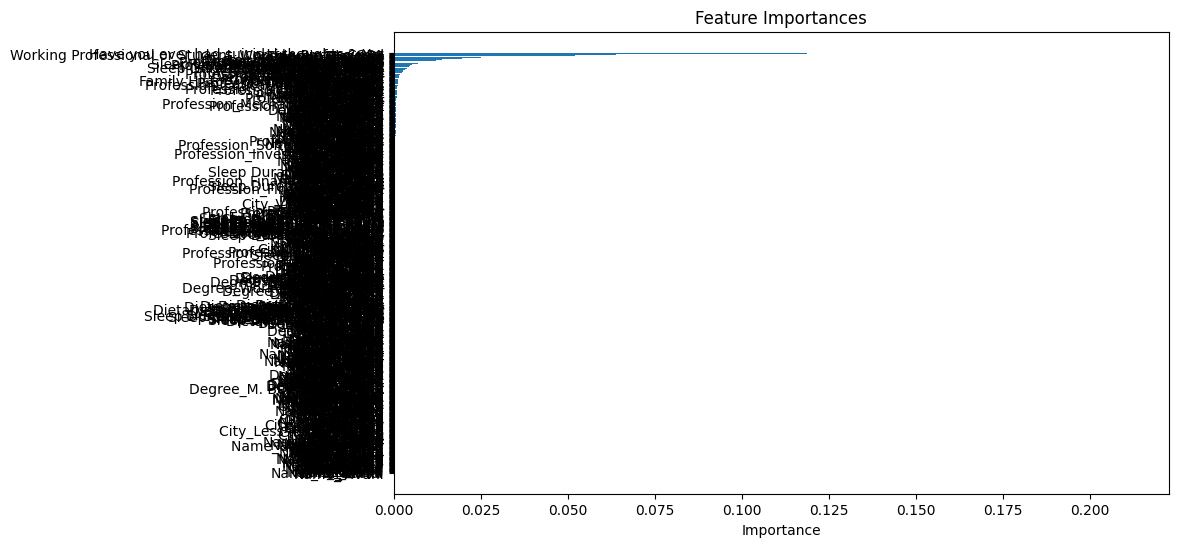

In [20]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

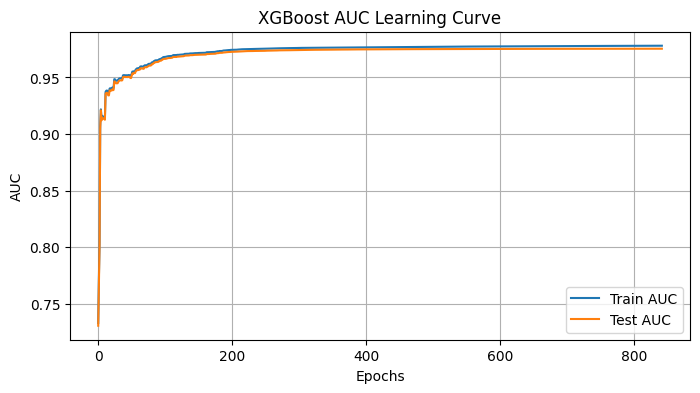

In [21]:
results = best_xgb.evals_result()

epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

plt.figure(figsize=(8,4))
plt.plot(x_axis, results['validation_0']['auc'], label='Train AUC')
plt.plot(x_axis, results['validation_1']['auc'], label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('XGBoost AUC Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
x_test_df = test[X_train.columns]

y_test_pred = best_xgb.predict(x_test_df)

test['predicted'] = y_test_pred

print(test[['predicted']])

       predicted
0              0
1              0
2              0
3              1
4              0
...          ...
93795          0
93796          1
93797          0
93798          1
93799          0

[93800 rows x 1 columns]
